- transform boundaries of all cellpose and negative_contorol runs from pixel to um 
- replace in master sdata
- exception: Cellpose_1_Merlin, which is alredy at correct scale
- in future, directly run after sopa

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import json
import spatialdata as sd

In [3]:
import spatialdata_plot

In [4]:
data_dir = os.path.abspath("../data")
archive_dir = os.path.abspath("../archive")

In [5]:
sample_name = "foxf2_s2_r1"

In [6]:
sdata_path = os.path.join(data_dir, "samples", sample_name, "sdata_z3.zarr")
sdata = sd.read_zarr(sdata_path)

In [7]:
sdata.shapes.keys()

dict_keys(['boundaries_Baysor_2D_CP1Merlin_075', 'boundaries_Baysor_2D_CP1_020', 'boundaries_Baysor_2D_CP1_080', 'boundaries_Baysor_2D_CP2_020', 'boundaries_Baysor_2D_CP2_080', 'boundaries_Baysor_2D_nucleus_100', 'boundaries_Baysor_3D', 'boundaries_Cellpose_1_DAPI_PolyT', 'boundaries_Cellpose_1_DAPI_Transcripts', 'boundaries_Cellpose_1_Merlin', 'boundaries_Cellpose_1_nuclei_model', 'boundaries_Cellpose_2_DAPI_PolyT', 'boundaries_Cellpose_2_DAPI_Transcripts', 'boundaries_ComSeg', 'boundaries_Negative_Control_Rastered_10', 'boundaries_Negative_Control_Rastered_20', 'boundaries_Negative_Control_Rastered_50', 'boundaries_Negative_Control_Voronoi', 'boundaries_Proseg', 'transcripts_patches'])

In [8]:
micron_keys = [k for k in sdata.shapes.keys() if "_micron" in k]
micron_keys

[]

In [9]:
#for key in micron_keys:
#   del sdata[key]

# transform pixel to um

In [10]:
# all cellpose methods but Cellpose_1_Merlin

In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.affinity import affine_transform

def transform_cellpose_boundaries(sdata, transform_file, shape_patterns=None, exclude_patterns=None, overwrite=False):
    """
    Transform Cellpose boundaries from pixels to microns
    
    Parameters:
    -----------
    sdata : SpatialData
        SpatialData object containing shape collections
    transform_file : str
        Path to file containing transformation matrix
    shape_patterns : list, optional
        List of patterns to match for shape names
    exclude_patterns : list, optional
        List of patterns to exclude from shape names
    overwrite : bool, optional
        Whether to overwrite existing shapes (default: False)
    """
    
    # Load and invert transform matrix
    transform_matrix = pd.read_csv(transform_file, sep=" ", header=None).values
    inv_matrix = np.linalg.inv(transform_matrix)
    
    # Convert matrix to affine transform coefficients
    transform_coeffs = (
        inv_matrix[0, 0], inv_matrix[0, 1], 
        inv_matrix[1, 0], inv_matrix[1, 1],
        inv_matrix[0, 2], inv_matrix[1, 2]
    )
    
    # Track number of transformations
    transform_count = 0
    
    # Process eligible shapes
    for shape_name in list(sdata.shapes.keys()):
        # Check if shape name matches any of the patterns and doesn't match any exclude patterns
        if any(pattern in shape_name for pattern in shape_patterns) and \
           not any(exclude in shape_name for exclude in exclude_patterns):
            print(f"Transforming {shape_name}...")
            
            # Get boundaries
            boundaries = sdata.shapes[shape_name]
            
            # Create transformed geometries
            transformed_geoms = boundaries['geometry'].apply(lambda g: affine_transform(g, transform_coeffs))
            
            # Create new GeoDataFrame
            transformed_boundaries = gpd.GeoDataFrame(
                boundaries.drop(columns=['geometry']), 
                geometry=transformed_geoms,
                crs=boundaries.crs
            )
            
            # Copy attributes
            for key, value in boundaries.attrs.items():
                transformed_boundaries.attrs[key] = value
            
            # Determine output name
            output_name = shape_name if overwrite else f"{shape_name}_microns"
                
            # Add to spatialdata
            sdata.shapes[output_name] = transformed_boundaries
            transform_count += 1
    
    print(f"Transformed {transform_count} shape collections.")

In [16]:
# get micron_to_mosaic_pixel_transform.csv
with open(os.path.join(data_dir, "sample_paths.json"), 'r') as f:
   output_path = json.load(f)

In [17]:
shape_patterns = ["Cellpose", "Negative_Control_Rastered"]
shape_patterns = ["Negative_Control"]
exclude_patterns = ["Cellpose_1_Merlin"]

In [18]:
transform_cellpose_boundaries(
    sdata, 
    transform_file=os.path.join(output_path[sample_name], "images", "micron_to_mosaic_pixel_transform.csv"),
    shape_patterns=shape_patterns, 
    exclude_patterns=exclude_patterns,
    overwrite=False # adds *_micron boundary if false
)

# if boundary file is overwritten with same name, cannot be saved to disk
# therefore export as _micron, delete original boundaries and remove _micron suffix

Transforming boundaries_Negative_Control_Rastered_10...
Transforming boundaries_Negative_Control_Rastered_20...
Transforming boundaries_Negative_Control_Rastered_50...
Transforming boundaries_Negative_Control_Voronoi...
Transformed 4 shape collections.


In [19]:
sdata.shapes.keys()

dict_keys(['boundaries_Baysor_2D_CP1Merlin_075', 'boundaries_Baysor_2D_CP1_020', 'boundaries_Baysor_2D_CP1_080', 'boundaries_Baysor_2D_CP2_020', 'boundaries_Baysor_2D_CP2_080', 'boundaries_Baysor_2D_nucleus_100', 'boundaries_Baysor_3D', 'boundaries_Cellpose_1_DAPI_PolyT', 'boundaries_Cellpose_1_DAPI_Transcripts', 'boundaries_Cellpose_1_Merlin', 'boundaries_Cellpose_1_nuclei_model', 'boundaries_Cellpose_2_DAPI_PolyT', 'boundaries_Cellpose_2_DAPI_Transcripts', 'boundaries_ComSeg', 'boundaries_Negative_Control_Rastered_10', 'boundaries_Negative_Control_Rastered_20', 'boundaries_Negative_Control_Rastered_50', 'boundaries_Negative_Control_Voronoi', 'boundaries_Proseg', 'transcripts_patches', 'boundaries_Negative_Control_Rastered_10_microns', 'boundaries_Negative_Control_Rastered_20_microns', 'boundaries_Negative_Control_Rastered_50_microns', 'boundaries_Negative_Control_Voronoi_microns'])

In [20]:
micron_keys = [k for k in sdata.shapes.keys() if "_micron" in k]
micron_keys

['boundaries_Negative_Control_Rastered_10_microns',
 'boundaries_Negative_Control_Rastered_20_microns',
 'boundaries_Negative_Control_Rastered_50_microns',
 'boundaries_Negative_Control_Voronoi_microns']

In [21]:
cp_keys = [k for k in sdata.shapes.keys() if "Cellpose" in k]
cp_keys

['boundaries_Cellpose_1_DAPI_PolyT',
 'boundaries_Cellpose_1_DAPI_Transcripts',
 'boundaries_Cellpose_1_Merlin',
 'boundaries_Cellpose_1_nuclei_model',
 'boundaries_Cellpose_2_DAPI_PolyT',
 'boundaries_Cellpose_2_DAPI_Transcripts']

In [22]:
# save
for key in micron_keys:
   sdata.write_element(key, overwrite=True)

In [23]:
sdata

SpatialData object, with associated Zarr store: /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s2_r1/sdata_z3.zarr
├── Images
│     └── 'foxf2_s2_r1_z3': DataTree[cyx] (8, 54456, 65675), (8, 27228, 32837), (8, 13614, 16418), (8, 6807, 8209), (8, 3403, 4104)
├── Points
│     └── 'foxf2_s2_r1_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── 'boundaries_Baysor_2D_CP1Merlin_075': GeoDataFrame shape: (124658, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP1_020': GeoDataFrame shape: (145848, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP1_080': GeoDataFrame shape: (133435, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP2_020': GeoDataFrame shape: (148669, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP2_080': GeoDataFrame shape: (128401, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_nucleus_100': GeoDataFrame shape: (147154, 1) (2D shapes)
│     ├── 'boundaries_Baysor_3D': GeoDataFrame shape: (149500, 1) (2D shapes)
│     ├──

# plot

In [28]:
bd_name = "boundaries_Cellpose_2_DAPI_PolyT_microns"

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


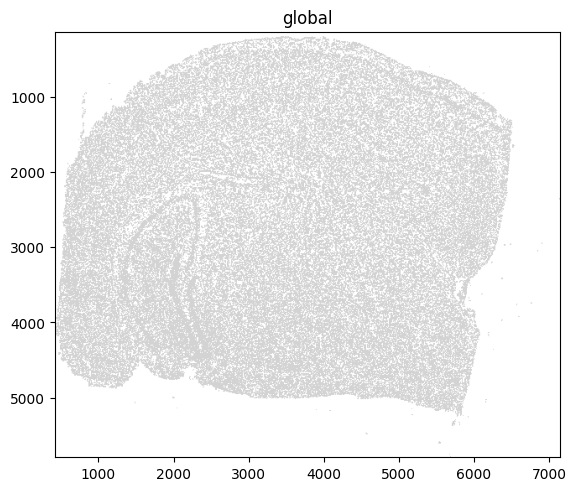

In [29]:
sdata.pl.render_shapes(element=bd_name).pl.show()

In [30]:
bd_name = "boundaries_Cellpose_2_DAPI_PolyT"

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


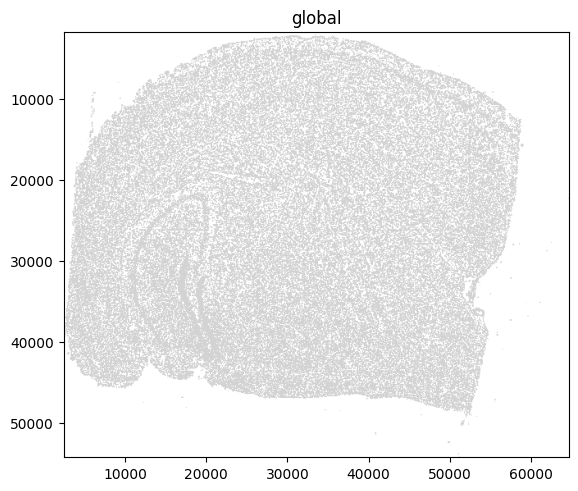

In [31]:
sdata.pl.render_shapes(element=bd_name).pl.show()

In [32]:
bd_name = "boundaries_Proseg"

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


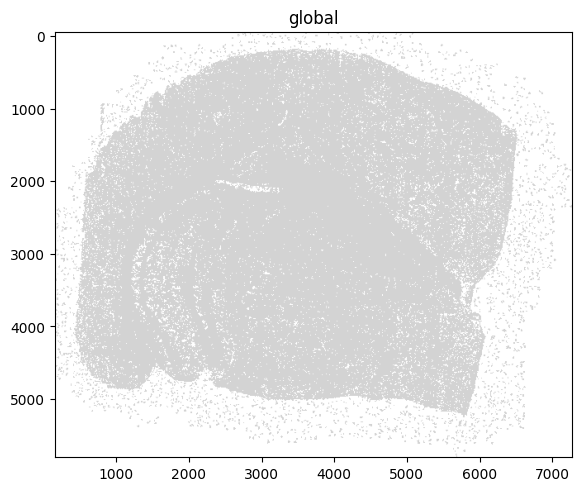

In [33]:
sdata.pl.render_shapes(element=bd_name).pl.show()

In [13]:
bd_name = "boundaries_Negative_Control_Voronoi"

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


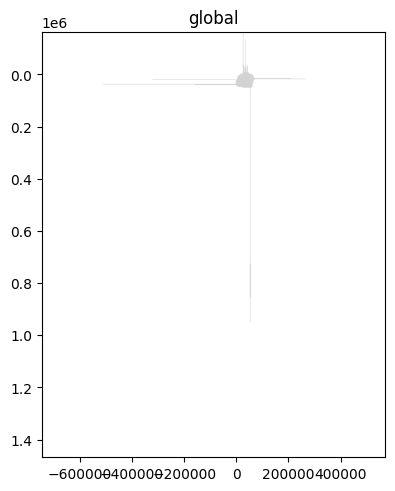

In [14]:
sdata.pl.render_shapes(element=bd_name).pl.show()

In [26]:
bd_name = "boundaries_Negative_Control_Voronoi_microns"

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


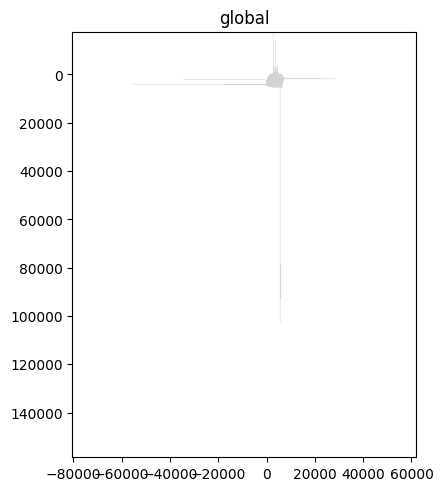

In [27]:
sdata.pl.render_shapes(element=bd_name).pl.show()